In [4]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

In [57]:
class LIFNeuron(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 c_m = 1, r_m = 10, v_reset = -70, refrac_time = 10, v_th = -50, e_l = -75, i_e = 0, dt = 0.05,
                 g_ampa = 0, g_gaba = 0,
                ):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()

        ### assign the attributes of the class
        self.r_m = r_m # membrane resistance in M Ohm/cm**2
        self.tau_m = self.r_m * c_m  # membrane time constant
        self.e_l = e_l # leak reversal potential

        
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.i_e = i_e # Input current


        self.v = self.e_l # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        
        ''' refractory period '''
        self.refrac_time = refrac_time # in ms
        self.refrac_tracker = 0
        ''' refractory period '''
        
        self.v_list = [self.v]
        self.t_list = [0]
        self.i_e_list = [self.i_e]
        
        self.spike_times = []
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = 0 # when starting the simulations the channels should be closed
        self.ampa_input = False # and there is no input
        self.g_ampa = g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = 0 # when starting the simulations the channels should be closed
        self.gaba_input = False # and there is no input
        self.g_gaba = g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms


    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        ### Time evolution of the synaptic input
        if self.ampa_input == True:
            self.ps_ampa = 1 # if there is a spike in this time step, the channels open
            self.ampa_input = False # remove the input 
        else:
            dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
            self.ps_ampa += dps_ampa_dt * self.dt
            
        if self.gaba_input == True:
            self.ps_gaba = 1 # if there is a spike in this time step, the channels open
            self.gaba_input = False # remove the input 
        else:
            dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
            self.ps_gaba += dps_gaba_dt * self.dt

        
        
            
        ### Time evolution of the membrane potential
        current_time = self.t_list[-1] + self.dt
        
        
        ''' refractory period '''
        if self.refrac_tracker > 0:
            self.refrac_tracker -= self.dt
            
        
        else:
            i_ampa = self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)
            i_gaba = self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)



            ### Time evolution of the membrane potential
            if self.v <= self.v_th:
                dv_dt = (-self.v + self.e_l + self.r_m * self.i_e + self.r_m*i_ampa + self.r_m*i_gaba )/self.tau_m
                self.v += dv_dt * self.dt
            else:
                # here we implement a spiking behavior (mainly just for the look)
                if self.v != 40:
                    self.v = 40
                else:
                    self.v = self.v_reset
                    self.refrac_tracker = self.refrac_time
                    self.spike_times.append(current_time)
                
                
                
        self.v_list.append(self.v)
        self.t_list.append(current_time) 
        self.i_e_list.append(self.i_e)


    def run_simulation(self, time_steps = 100, 
                       i_e_array = np.array([]), # we can provide an array for the input current. 
                 # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                       ampa_inputs = [],
                       gaba_inputs = [],
                      ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''

        for ii in range(time_steps):
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
                
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in ampa_inputs:
                self.ampa_input = True
            
            if ii in gaba_inputs:
                self.gaba_input = True
            
            
            self.timestep()
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

(array([5., 5., 2., 1., 4., 1., 0., 1., 1., 3.]),
 array([14.5 , 22.19, 29.88, 37.57, 45.26, 52.95, 60.64, 68.33, 76.02,
        83.71, 91.4 ]),
 <BarContainer object of 10 artists>)

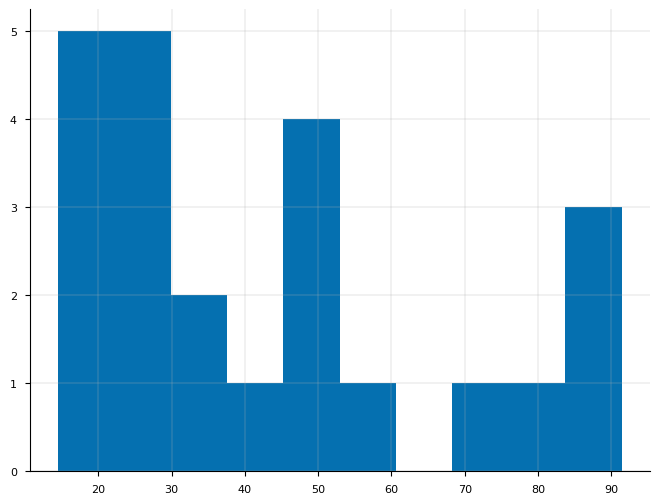

In [72]:
def transform_to_event_input(binned_spikes, bin_size=0.1):
    bin_offset = 5
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times



output_neuron = LIFNeuron()


def create_poisson_process(time_steps, rate,dt):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)'''
    
    rate = rate*1e-3 # rate is usually given in 1/s , we need 1/ms

    x = np.zeros(time_steps)
    x[np.random.rand(time_steps) <= rate*dt] = 1
    
    _, events = transform_to_event_input(x, bin_size=dt)

    return events


def run_and_plot_simulation_for_inputs(time_steps = 10000,
                              rate_excitatory_input = 100,
                              rate_inhibitory_input = 100,
                              show_plot = True):
    dt = 0.1


    poisson_excitatory_input = create_poisson_process(time_steps, rate_excitatory_input,dt)
    poisson_inhibitory_input = create_poisson_process(time_steps, rate_inhibitory_input,dt)
    
    ampa_inputs = (poisson_excitatory_input/dt).astype(int)
    gaba_inputs = (poisson_inhibitory_input/dt).astype(int)
    neuron = LIFNeuron(g_ampa = 0.15, g_gaba = 0.1, dt=dt)
    neuron.run_simulation(time_steps, 
                        ampa_inputs = ampa_inputs,
                       gaba_inputs = gaba_inputs,
                       )
    
    
    if show_plot:
        fig, (ax, ax_2) = plt.subplots(2, sharex = True)

        ax.eventplot(poisson_excitatory_input)
        ax.eventplot(poisson_inhibitory_input,lineoffsets=3, color = 'r')
        ax.set_yticks([1, 3])
        ax.set_yticklabels(['Excitation', 'Inhibition'])

        ax_2.plot(neuron.t_list,neuron.v_list,linewidth=2.5)
        ax_2.set_xlabel('Time in ms')
        ax_2.set_ylabel('Membrane Voltage in mV')
    
    return neuron.spike_times

spike_times = run_and_plot_simulation_for_inputs(time_steps = 10000,
                              rate_excitatory_input = 100,
                              rate_inhibitory_input = 100,
                            show_plot = False)

ISI = np.array(spike_times)[1:] - np.array(spike_times)[:-1]
fig, ax = plt.subplots()
ax.hist(ISI, bins=10)

In [3]:
def input_signal(rate_max_Hz=100, ipd_deg=90, f_Hz=3):
    # We can't use values with units in the widgets, so we add the units first
    rate_max = rate_max_Hz
    ipd = (pi/180)*ipd_deg
    f = f_Hz
    
    # These are the equations governing the ear neurons. Take a look at the
    # Brian documentation for an explanation, but the only thing you might
    # find non-obvious hopefully is the ": 1" and ": Hz" which tells Brian
    # what the units of the variable being defined are (1 means dimensionless).
    # Also note that the variable "i" is defined in Brian to be the index of
    # the neuron, so for neuron 0 it will be 0 and for neuron 1 it will be 1,
    # allowing us to make the input signal different for the two ears.
    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    rate = rate_max*0.5*(1+sin(theta)) : Hz
    '''
    
    # Create a group of 2 neurons with these equations, that fires a spike
    # according to a Poisson process with the given time-varying rate. We
    # use a dt of 1ms to speed up the simulation for interactivity, but later
    # we'll use a better default of 0.1ms.
    ears = NeuronGroup(2, eqs_ears, threshold='rand()<rate*dt', dt=1*ms)
    
    # Record the spikes and values of the rate as we run the simulation
    M_spike = SpikeMonitor(ears)
    M_state = StateMonitor(ears, 'rate', record=True)
    
    # Run the simulation for 1 second
    run(1*second)

    # Now plot the results. I won't explain in detail because it's mostly
    # just fiddly matplotlib stuff to make it look nice.
    trains = M_spike.spike_trains()
    fig = figure(figsize=(4, 2), dpi=200)
    gs = gridspec.GridSpec(2, 1, hspace=0, height_ratios=[1, .3])
    ax = subplot(gs[0])
    plot(M_state.t/ms, M_state.rate[0]/Hz, label='Left ear')
    plot(M_state.t/ms, M_state.rate[1]/Hz, label='Right ear')
    legend(loc='upper right')
    gca().set_frame_on(False)
    ylabel('Rate')
    yticks([])
    xticks([])
    ylim(-10, 210)
    subplot(gs[1], sharex=ax)
    plot(trains[0]/ms, [0]*len(trains[0]), '|')
    plot(trains[1]/ms, [1]*len(trains[1]), '|')
    ylim(-1, 2)
    gca().set_frame_on(False)
    xlabel('Time')
    ylabel('Spikes')
    yticks([])
    xticks([])
    tight_layout()

if widgets is not None:
    widgets.interact(input_signal,
        rate_max_Hz=widgets.IntSlider(min=10, max=200, value=100, step=10, continuous_update=False),
        ipd_deg=widgets.IntSlider(min=0, max=360, value=90, step=10, continuous_update=False),
        f_Hz=widgets.FloatSlider(min=0, max=10, value=3, step=.1, continuous_update=False),
        );
else:
    input_signal()

interactive(children=(IntSlider(value=100, continuous_update=False, description='rate_max_Hz', max=200, min=10…